In [800]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve


In [801]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

df_test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,15000,40.0,175.0,70.0,84.0,1.5,1.5,1.0,1.0,120.0,59.0,100.0,179.0,122.0,45.0,109.0,16.0,1.0,1.0,15.0,9.0,25.0,0.0
1,15001,45.0,155.0,55.0,72.4,0.6,0.5,1.0,1.0,102.0,68.0,87.0,186.0,104.0,56.0,109.0,11.5,1.0,0.8,14.0,10.0,13.0,0.0
2,15002,40.0,160.0,55.0,76.0,1.2,1.2,1.0,1.0,115.0,64.0,93.0,167.0,84.0,77.0,74.0,13.3,1.0,0.8,14.0,10.0,11.0,0.0
3,15003,45.0,150.0,50.0,74.4,1.0,1.0,1.0,1.0,96.0,67.0,72.0,179.0,63.0,85.0,82.0,13.4,1.0,0.7,23.0,15.0,18.0,0.0
4,15004,35.0,185.0,80.0,90.0,0.8,1.0,1.0,1.0,113.0,73.0,82.0,183.0,89.0,59.0,105.0,15.6,1.0,0.9,16.0,26.0,20.0,0.0


In [802]:
df_train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,74.0,82.0,175.0,58.0,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,0.0
1,1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,84.0,95.0,188.0,128.0,51.0,111.0,16.2,1.0,0.9,30.0,39.0,92.0,0.0,1.0
2,2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,80.0,98.0,192.0,138.0,52.0,112.0,14.6,2.0,0.9,20.0,20.0,50.0,0.0,1.0
3,3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,79.0,95.0,193.0,65.0,61.0,119.0,13.4,1.0,0.8,25.0,20.0,18.0,0.0,0.0
4,4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,76.0,103.0,197.0,81.0,61.0,120.0,13.9,1.0,0.7,20.0,26.0,10.0,0.0,0.0


# Feature engeenering

In [803]:
# Create new features for train


# 2. BMI (Body Mass Index) = weight(kg) / height(m)^2
df_train['bmi'] = df_train['weight(kg)'] / (df_train['height(cm)'] / 100) ** 2

# 3. Waist-to-Height Ratio
df_train['waist_to_height_ratio'] = df_train['waist(cm)'] / df_train['height(cm)']

# 4. Blood Pressure Difference (Systolic - Relaxation)
df_train['bp_difference'] = df_train['systolic'] - df_train['relaxation']

# Check the new features
df_train[[ 'bmi', 'waist_to_height_ratio', 'bp_difference']].head()


,bmi,waist_to_height_ratio,bp_difference
0,27.681661,0.541176,55.0
1,27.681661,0.552941,44.0
2,25.951557,0.494118,44.0
3,24.444444,0.566667,44.0
4,21.484375,0.450000,41.0


In [804]:
# Create new features for test



# 2. BMI (Body Mass Index) = weight(kg) / height(m)^2
df_test['bmi'] = df_test['weight(kg)'] / (df_test['height(cm)'] / 100) ** 2

# 3. Waist-to-Height Ratio
df_test['waist_to_height_ratio'] = df_test['waist(cm)'] / df_test['height(cm)']

# 4. Blood Pressure Difference (Systolic - Relaxation)
df_test['bp_difference'] = df_test['systolic'] - df_test['relaxation']

# Check the new features
df_test[[ 'bmi', 'waist_to_height_ratio', 'bp_difference']].head()

,bmi,waist_to_height_ratio,bp_difference
0,22.857143,0.480000,61.0
1,22.892820,0.467097,34.0
2,21.484375,0.475000,51.0
3,22.222222,0.496000,29.0
4,23.374726,0.486486,40.0


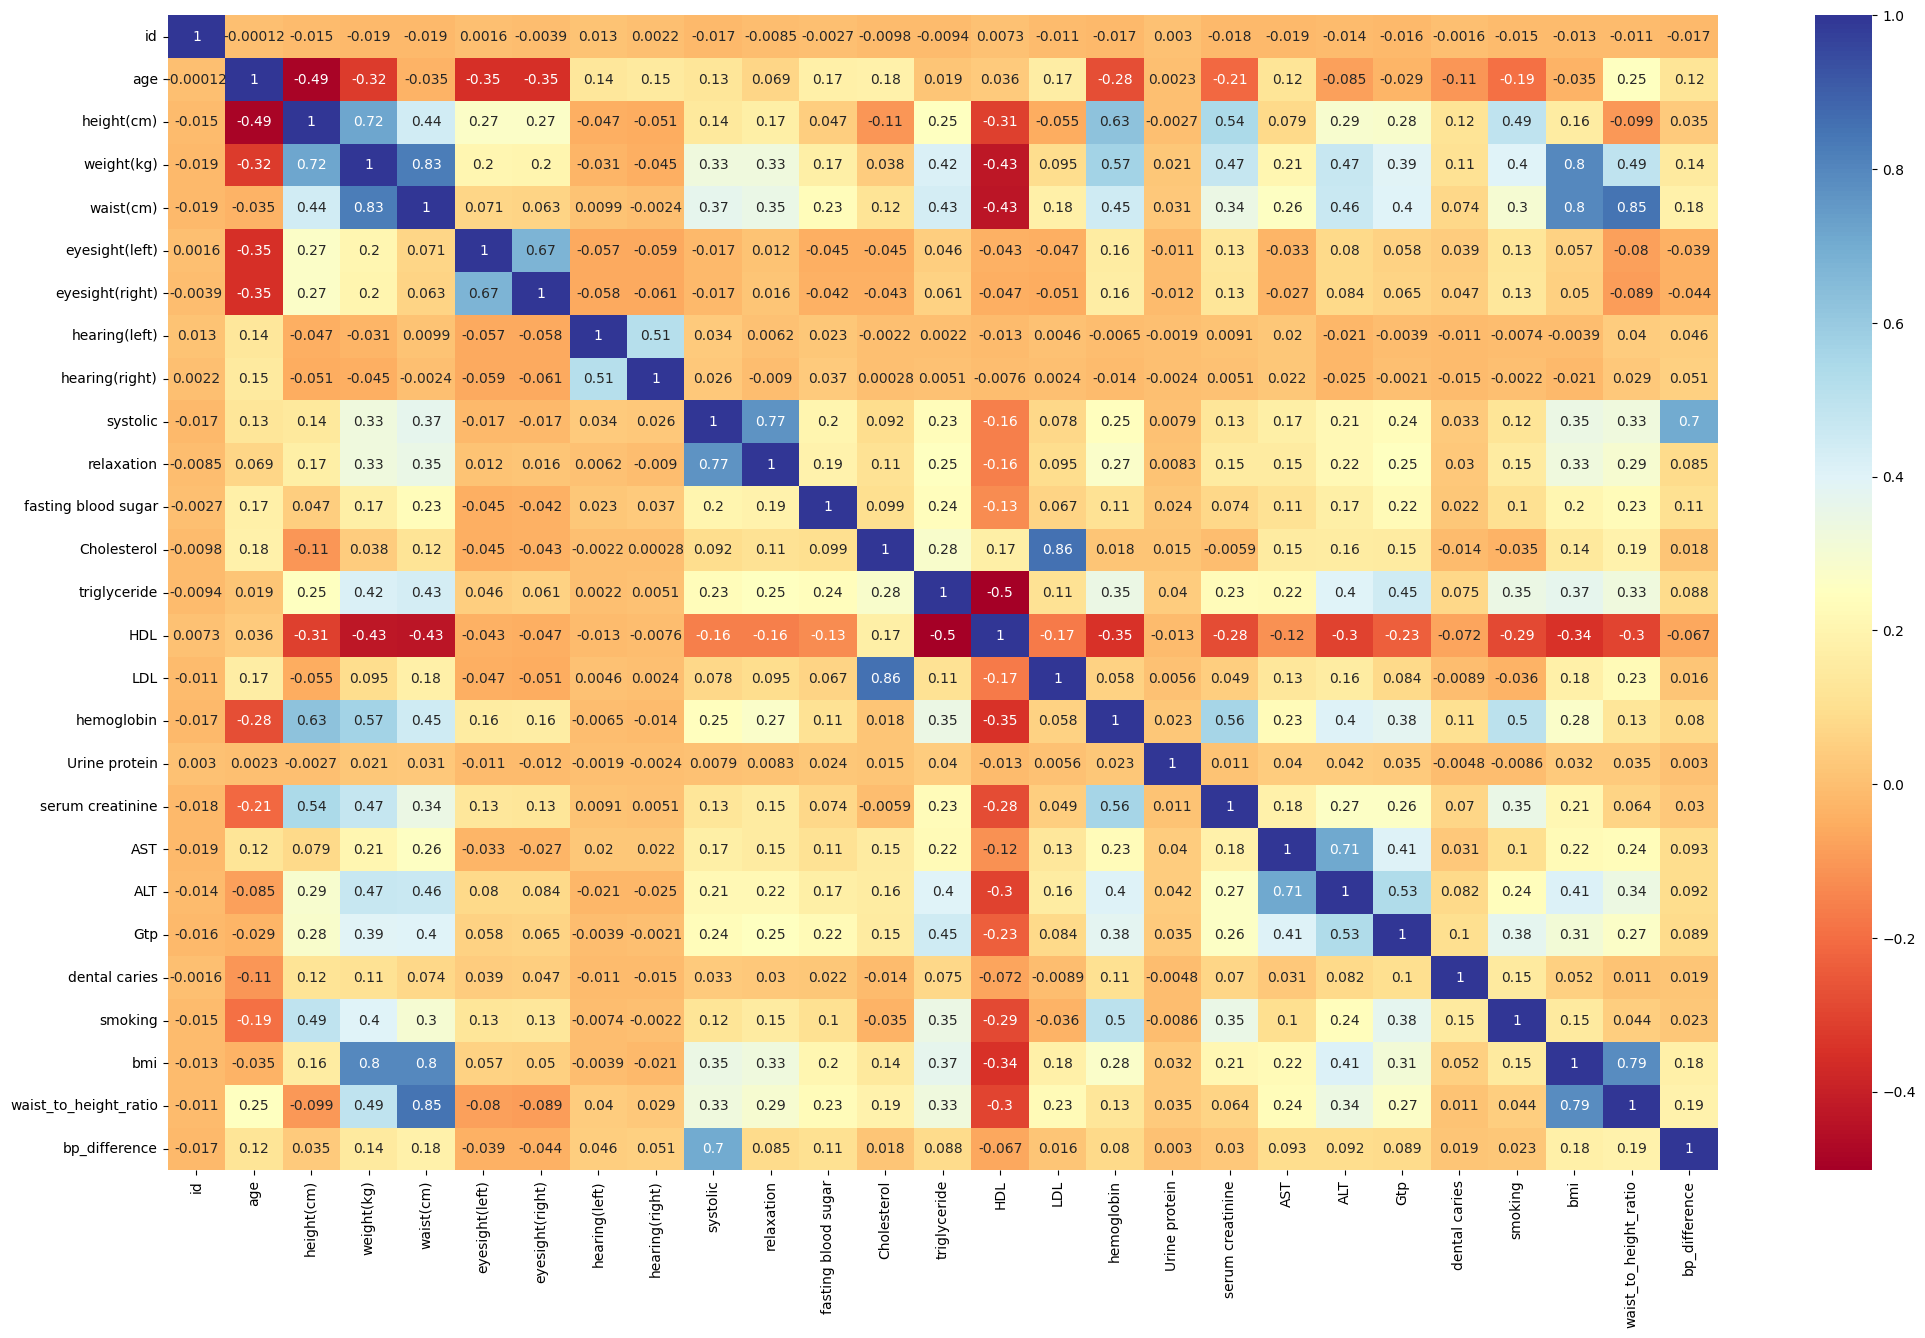

In [805]:
plt.subplots(figsize=(25,15))
sns.heatmap(df_train.corr(), annot=True, cmap="RdYlBu")
plt.show()

In [806]:
def WoE(data, feature_name, target_name):
    df = data.copy()
    
    # Group by the feature and calculate the count of events and non-events
    woe_table = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})
    
    # Calculate percentages
    woe_table['Percentage events'] = woe_table['# of events'] / woe_table['# of events'].sum()
    woe_table['Percentage non-events'] = woe_table['# of non-events'] / woe_table['# of non-events'].sum()
    
    # Calculate WoE
    woe_table['WoE'] = np.log(woe_table['Percentage events'] / woe_table['Percentage non-events'])
    
    # Add total observations and their percentage
    woe_table['Total Observations'] = woe_table['# of events'] + woe_table['# of non-events']
    woe_table['Percent of Observations'] = (woe_table['Total Observations'] / woe_table['Total Observations'].sum() * 100).round(3)

    return woe_table.reset_index()

In [807]:
# Create WoE plot Function 

def WoE_plot(df_woe,x_category,Woe):
    fig, ax1 = plt.subplots(figsize=(10, 6))  # Define a figure with an axis for the pointplot
    ax2 = ax1.twinx()  # Create a secondary y-axis to plot the barplot

    # Create the pointplot on the primary axis (ax1)
    sns.pointplot(data=df_woe, x=x_category, y=Woe, color='red', linewidth=2, ax=ax1)
    ax1.set_ylabel('Weight of Evidence (WoE)', color='red')
    ax1.tick_params(axis='y', colors='red')
    ax1.set_xlabel(f'{x_category}')
    # plt.xticks(rotation=45)
    # Set x-tick rotation directly on the x-axis for ax1
    for label in ax1.get_xticklabels():
        label.set_rotation(90)
    # Create the barplot on the secondary axis (ax2)
    sns.barplot(data=df_woe, x=x_category, y='Percent of Observations', alpha=0.3, ax=ax2)
    ax2.set_ylabel('Rate of Observations')
    ax2.set_ylim(0, df_woe['Percent of Observations'].max() * 1.2)  # Adjust y-limits if necessary
    ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
    # Set up the grids and display the plot
    ax1.grid(visible=True, which='major', linestyle='--')
    plt.title("WoE change plot")
    plt.show()

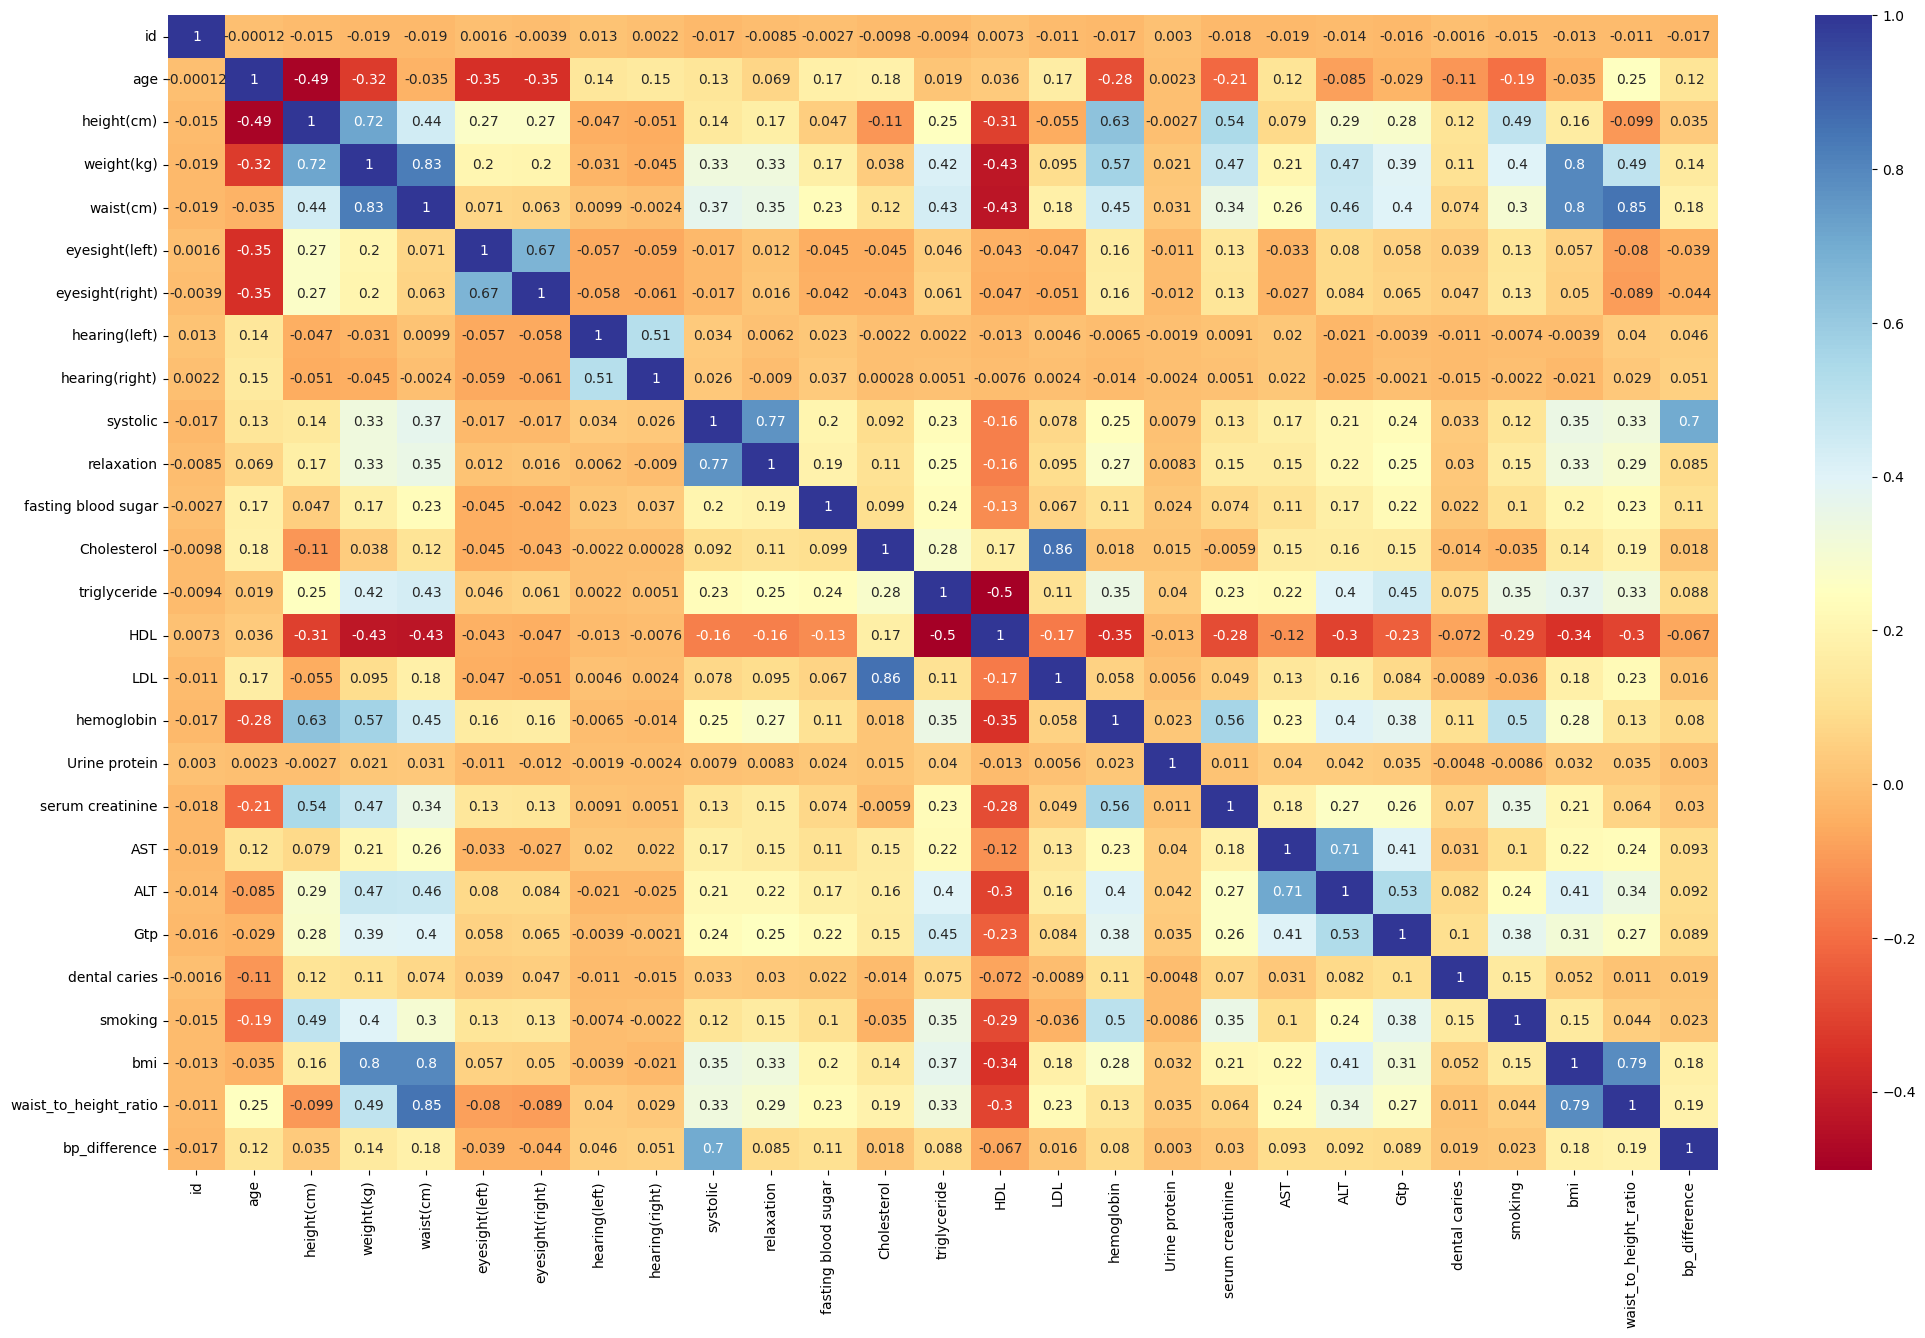

In [808]:
plt.subplots(figsize=(25,15))
sns.heatmap(df_train.corr(), annot=True, cmap="RdYlBu")
plt.show()

In [809]:
#df_train['HDL'] = -df_train['HDL']
#df_test['HDL'] = -df_test['HDL']

In [810]:
df_train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking,bmi,waist_to_height_ratio,bp_difference
0,0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,74.0,82.0,175.0,58.0,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,0.0,27.681661,0.541176,55.0
1,1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,84.0,95.0,188.0,128.0,51.0,111.0,16.2,1.0,0.9,30.0,39.0,92.0,0.0,1.0,27.681661,0.552941,44.0
2,2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,80.0,98.0,192.0,138.0,52.0,112.0,14.6,2.0,0.9,20.0,20.0,50.0,0.0,1.0,25.951557,0.494118,44.0
3,3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,79.0,95.0,193.0,65.0,61.0,119.0,13.4,1.0,0.8,25.0,20.0,18.0,0.0,0.0,24.444444,0.566667,44.0
4,4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,76.0,103.0,197.0,81.0,61.0,120.0,13.9,1.0,0.7,20.0,26.0,10.0,0.0,0.0,21.484375,0.450000,41.0


In [811]:
X = df_train.drop(columns=['smoking','id','hearing(left)','hearing(right)','Cholesterol'])
y = df_train['smoking']

df_test = df_test.drop(columns=['id','hearing(left)','hearing(right)','Cholesterol'])

In [812]:
from sklearn.preprocessing import PolynomialFeatures

In [813]:
# Step 2: Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)  # degree=2 for quadratic features
X_poly = poly.fit_transform(X)

# Step 3: Convert the transformed array back into a DataFrame with appropriate feature names
poly_feature_names = poly.get_feature_names_out(X.columns)
df_poly = pd.DataFrame(X_poly, columns=poly_feature_names)

# Split data into train and test for demonstration purposes
X_train, X_test, y_train, y_test = train_test_split(df_poly, y, test_size=0.3, random_state=42, stratify=y)

# Display the new polynomial features
df_poly.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,bmi,waist_to_height_ratio,bp_difference,age^2,age height(cm),age weight(kg),age waist(cm),age eyesight(left),age eyesight(right),age systolic,age relaxation,age fasting blood sugar,age triglyceride,age HDL,age LDL,age hemoglobin,age Urine protein,age serum creatinine,age AST,age ALT,age Gtp,...,Urine protein dental caries,Urine protein bmi,Urine protein waist_to_height_ratio,Urine protein bp_difference,serum creatinine^2,serum creatinine AST,serum creatinine ALT,serum creatinine Gtp,serum creatinine dental caries,serum creatinine bmi,serum creatinine waist_to_height_ratio,serum creatinine bp_difference,AST^2,AST ALT,AST Gtp,AST dental caries,AST bmi,AST waist_to_height_ratio,AST bp_difference,ALT^2,ALT Gtp,ALT dental caries,ALT bmi,ALT waist_to_height_ratio,ALT bp_difference,Gtp^2,Gtp dental caries,Gtp bmi,Gtp waist_to_height_ratio,Gtp bp_difference,dental caries^2,dental caries bmi,dental caries waist_to_height_ratio,dental caries bp_difference,bmi^2,bmi waist_to_height_ratio,bmi bp_difference,waist_to_height_ratio^2,waist_to_height_ratio bp_difference,bp_difference^2
0,55.0,170.0,80.0,92.0,1.2,0.8,129.0,74.0,82.0,58.0,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,27.681661,0.541176,55.0,3025.0,9350.0,4400.0,5060.0,66.0,44.0,7095.0,4070.0,4510.0,3190.0,2695.0,6270.0,847.0,55.0,49.5,1100.0,1265.0,715.0,...,0.0,27.681661,0.541176,55.0,0.81,18.0,20.7,11.7,0.0,24.913495,0.487059,49.5,400.0,460.0,260.0,0.0,553.633218,10.823529,1100.0,529.0,299.0,0.0,636.678201,12.447059,1265.0,169.0,0.0,359.861592,7.035294,715.0,0.0,0.0,0.0,0.0,766.274350,14.980664,1522.491349,0.292872,29.764706,3025.0
1,30.0,170.0,80.0,94.0,1.5,1.5,128.0,84.0,95.0,128.0,51.0,111.0,16.2,1.0,0.9,30.0,39.0,92.0,0.0,27.681661,0.552941,44.0,900.0,5100.0,2400.0,2820.0,45.0,45.0,3840.0,2520.0,2850.0,3840.0,1530.0,3330.0,486.0,30.0,27.0,900.0,1170.0,2760.0,...,0.0,27.681661,0.552941,44.0,0.81,27.0,35.1,82.8,0.0,24.913495,0.497647,39.6,900.0,1170.0,2760.0,0.0,830.449827,16.588235,1320.0,1521.0,3588.0,0.0,1079.584775,21.564706,1716.0,8464.0,0.0,2546.712803,50.870588,4048.0,0.0,0.0,0.0,0.0,766.274350,15.306330,1217.993080,0.305744,24.329412,1936.0
2,45.0,170.0,75.0,84.0,1.0,1.0,124.0,80.0,98.0,138.0,52.0,112.0,14.6,2.0,0.9,20.0,20.0,50.0,0.0,25.951557,0.494118,44.0,2025.0,7650.0,3375.0,3780.0,45.0,45.0,5580.0,3600.0,4410.0,6210.0,2340.0,5040.0,657.0,90.0,40.5,900.0,900.0,2250.0,...,0.0,51.903114,0.988235,88.0,0.81,18.0,18.0,45.0,0.0,23.356401,0.444706,39.6,400.0,400.0,1000.0,0.0,519.031142,9.882353,880.0,400.0,1000.0,0.0,519.031142,9.882353,880.0,2500.0,0.0,1297.577855,24.705882,2200.0,0.0,0.0,0.0,0.0,673.483316,12.823122,1141.868512,0.244152,21.741176,1936.0
3,55.0,150.0,55.0,85.0,0.9,0.5,123.0,79.0,95.0,65.0,61.0,119.0,13.4,1.0,0.8,25.0,20.0,18.0,0.0,24.444444,0.566667,44.0,3025.0,8250.0,3025.0,4675.0,49.5,27.5,6765.0,4345.0,5225.0,3575.0,3355.0,6545.0,737.0,55.0,44.0,1375.0,1100.0,990.0,...,0.0,24.444444,0.566667,44.0,0.64,20.0,16.0,14.4,0.0,19.555556,0.453333,35.2,625.0,500.0,450.0,0.0,611.111111,14.166667,1100.0,400.0,360.0,0.0,488.888889,11.333333,880.0,324.0,0.0,440.000000,10.200000,792.0,0.0,0.0,0.0,0.0,597.530864,13.851852,1075.555556,0.321111,24.933333,1936.0
4,45.0,160.0,55.0,72.0,0.5,0.6,117.0,76.0,103.0,81.0,61.0,120.0,13.9,1.0,0.7,20.0,26.0,10.0,0.0,21.484375,0.450000,41.0,2025.0,7200.0,2475.0,3240.0,22.5,27.0,5265.0,3420.0,4635.0,3645.0,2745.0,5400.0,625.5,45.0,31.5,900.0,1170.0,450.0,...,0.0,21.484375,0.450000,41.0,0.49,14.0,18.2,7.0,0.0,15.039062,0.315000,28.7,400.0,520.0,200.0,0.0,429.687500,9.000000,820.0,676.0,260.0,0.0,558.593750,11.700000,1066.0,100.0,0.0,214.843750,4.500000,410.0,0.0,0.0,0.0,0.0,461.578369,9.667969,880.859375,0.202500,18.450000,1681.0


In [814]:
# Step 2: Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)  # degree=2 for quadratic features
X_poly = poly.fit_transform(df_test)

# Step 3: Convert the transformed array back into a DataFrame with appropriate feature names
poly_feature_names = poly.get_feature_names_out(df_test.columns)
df_poly_test = pd.DataFrame(X_poly, columns=poly_feature_names)

In [815]:
model = RandomForestClassifier(
        n_estimators=235,
        max_depth=9,
        min_samples_split=4,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=False,
        random_state=42,
        n_jobs=-1
    )

roc_auc_train = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc", n_jobs=-1).mean()
roc_auc_test = cross_val_score(model, X_test, y_test, cv=3, scoring="roc_auc", n_jobs=-1).mean()
print(roc_auc_train)
print(roc_auc_test)


0.8828081766650214
0.8761627657179027


ROC AUC Score: 0.88


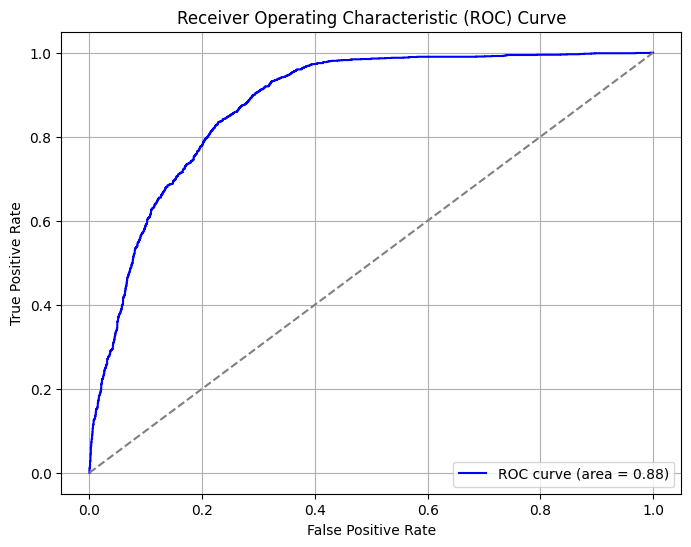

In [816]:
# Get the predicted probabilities for the positive class (class 1)
model.fit(X_train,y_train)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc:.2f}')

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [817]:
df_test.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,bmi,waist_to_height_ratio,bp_difference
0,40.0,175.0,70.0,84.0,1.5,1.5,120.0,59.0,100.0,122.0,45.0,109.0,16.0,1.0,1.0,15.0,9.0,25.0,0.0,22.857143,0.480000,61.0
1,45.0,155.0,55.0,72.4,0.6,0.5,102.0,68.0,87.0,104.0,56.0,109.0,11.5,1.0,0.8,14.0,10.0,13.0,0.0,22.892820,0.467097,34.0
2,40.0,160.0,55.0,76.0,1.2,1.2,115.0,64.0,93.0,84.0,77.0,74.0,13.3,1.0,0.8,14.0,10.0,11.0,0.0,21.484375,0.475000,51.0
3,45.0,150.0,50.0,74.4,1.0,1.0,96.0,67.0,72.0,63.0,85.0,82.0,13.4,1.0,0.7,23.0,15.0,18.0,0.0,22.222222,0.496000,29.0
4,35.0,185.0,80.0,90.0,0.8,1.0,113.0,73.0,82.0,89.0,59.0,105.0,15.6,1.0,0.9,16.0,26.0,20.0,0.0,23.374726,0.486486,40.0


In [819]:
# Get the predicted probabilities for the positive class (class 1)
model.fit(X_train,y_train)
y_prob = model.predict_proba(df_poly_test)[:, 1]


In [820]:
submission.head()

,id,smoking
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [821]:
submission['smoking'] = y_prob

submission.to_csv('my_submission.csv',index=False)

submission

,id,smoking
0,15000,0.738140
1,15001,0.013579
2,15002,0.015551
3,15003,0.029981
4,15004,0.492948
...,...,...
9995,24995,0.404368
9996,24996,0.783467
9997,24997,0.366121
9998,24998,0.011841
